In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import zipfile
import os
import shutil 
from tqdm import tqdm
import pickle


import torch
import torchvision
from torchvision import transforms, models, datasets

from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import manifold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

%matplotlib
%pylab inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/ila/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Знакомство с данными  


In [34]:
!rm -rf train
!rm -rf test
!rm -rf val
!rm -rf '../data/closed'
!rm -rf '../data/open'
!rm -rf '../data/EyesDataset'

In [7]:
with zipfile.ZipFile('../data/closed.zip', 'r') as zip_obj:
    zip_obj.extractall('data/')
    
with zipfile.ZipFile('../data/open.zip', 'r') as zip_obj:
    zip_obj.extractall('data/')
    
with zipfile.ZipFile('../data/EyesDataset.zip', 'r') as zip_obj:
    zip_obj.extractall('data/')

In [8]:
data_root = ''
train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

class_names = ['closed', 'open']
files = []
for dir_name in [train_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
        
for class_name in class_names:
    source_dir = os.path.join(data_root, 'data', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 3 == 0:
            dest_dir = os.path.join(test_dir, class_name) 
        else:
            dest_dir = os.path.join(train_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        
yes_label = os.listdir('data/open') + os.listdir('data/closed')
no_label  = set(os.listdir('data/EyesDataset')) - set(yes_label)
os.makedirs(os.path.join(val_dir, 'train'), exist_ok=True)
source_dir = os.path.join(data_root, 'data/EyesDataset')
for file_name in no_label:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(os.path.join(val_dir, 'train'), file_name))

100%|██████████| 1996/1996 [00:00<00:00, 2405.44it/s]


In [9]:
! ls -la ./train/open/ | wc
! ls -la ./train/closed/ | wc
! ls -la ./test/open/ | wc
! ls -la ./test/closed/ | wc
! ls -la ./val/train/ | wc

    1333   11990   78583
    1261   11342   74335
     669    6014   38738
     632    5681   36592
     120    1073    6776


всего 4000 одноканальных фотографий, каждая из которых 24 на 24 размером, яркость пикселя уже отнормирована от 0 до 1 

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [10]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [11]:
def augmentation(train_dir = 'train'):
    mas = [transforms.RandomVerticalFlip(p=1), transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.5, hue=.3), transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomAffine(degrees=(30, 70)), transforms.RandomEqualize(p=1)]
    ten = transforms.ToTensor()
    com_mas = []
    for i in range(len(mas)):
        com_mas.append(transforms.Compose([mas[i], ten]))
        for j in range(i+1, len(mas)):
            com_mas.append(transforms.Compose([mas[i], mas[j], ten]))
            for l in range(j+1, len(mas)):
                if l > j+2:
                    break
                com_mas.append(transforms.Compose([mas[i], mas[j], mas[l], ten]))
    dataset_mas = []
    for com in com_mas:
        dataset_mas.append(torchvision.datasets.ImageFolder(train_dir, com))
        
    return torch.utils.data.ConcatDataset(dataset_mas)

In [12]:
def val_load():
    val_transforms = transforms.Compose([
    transforms.ToTensor()])
    val_dataset = ImageFolderWithPaths(val_dir, val_transforms) 
    val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=False)
    return val_dataset, val_dataloader


def train_load():
    train_dataset = augmentation()
    batch_size = 18
    train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
    return train_dataset, train_dataloader

In [13]:
test_transforms = transforms.Compose([
    transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(test_dir, test_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=8)


val_dataset, val_dataloader = val_load()
train_dataset, train_dataloader = train_load()

/Users/ila/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
print(len(train_dataset)) ## кол-во всех фотографий
print(len(train_dataloader)) ## кол-во батчей
print(train_dataset[0][0].shape) ## размерность изображения

95756
5320
torch.Size([3, 24, 24])


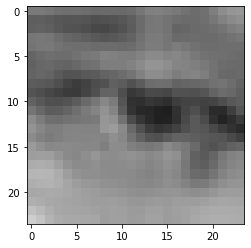

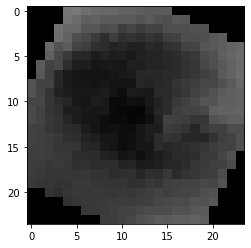

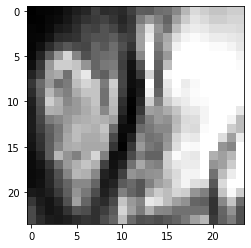

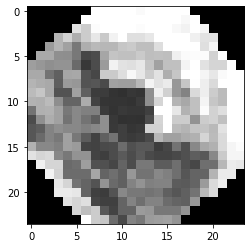

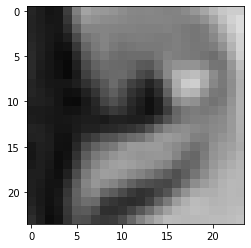

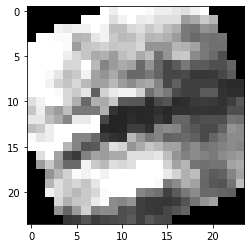

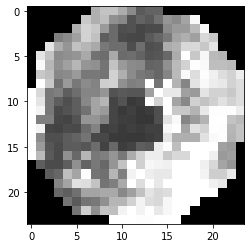

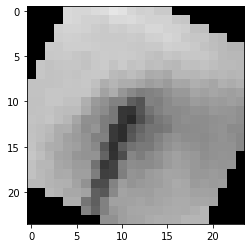

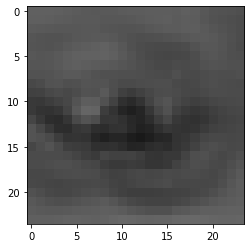

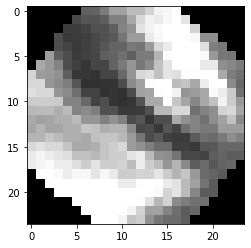

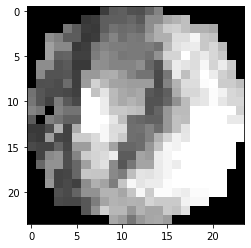

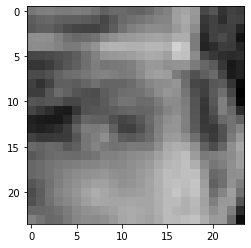

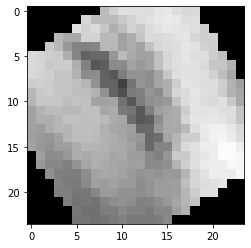

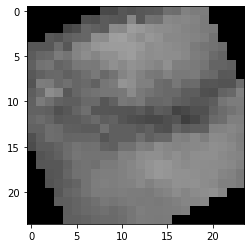

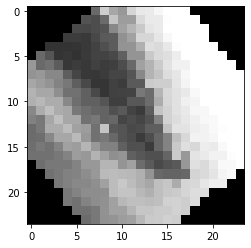

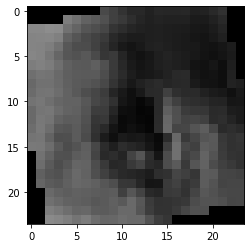

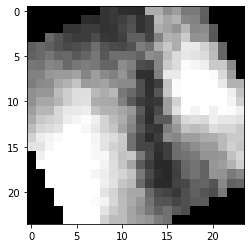

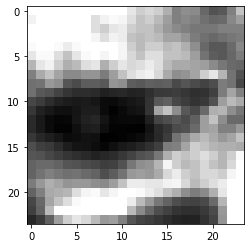

In [15]:
def show_input(input_tensor, title = None):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image, cmap='gray')
    if title != None:
        plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item)

## Обучим модель на части размеченных данных 

In [16]:
class OpenEyesClassificator:
    def __init__(self, name_model = None, early_stopping = 0.05, num_epochs = 100):
        if name_model == None:
            self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 2)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.loss = torch.nn.CrossEntropyLoss() # функция активации 
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1.0e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)
        self.num_epochs = num_epochs
        self.early_stopping = early_stopping
    
    def fit(self, train_dataloader, val_dataloader):
        for epoch in range(self.num_epochs):
            print('Epoch {}/{}:'.format(epoch, self.num_epochs), flush=True)
        
            # Each epoch has a training and validation phase
            """Для каждой эпохи есть фаза обучения и валидации"""
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    self.scheduler.step()
                    """нужно для того, что бы зафиксировать слои нормализации и просто на всякий случай"""
                    self.model.train() 
                else:
                    dataloader = val_dataloader
                    """что бы во время валидации не изменялась нейронка"""
                    self.model.eval() 
    

    
                """Iterate over data."""
                correct = 0
                total = 0
                all_loss = 0
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    """обнуляем градиент, что бы он не накапливался каждый раз"""
                    self.optimizer.zero_grad()
    
                    """Активируем все градиенты(веса), которые не заморожены"""
                    with torch.set_grad_enabled(phase == 'train'):
                        """Считаем предикшн модели, это не вероятности, а просто аквации нейронов"""
                        preds = self.model(inputs) 
                        loss_value = self.loss(preds, labels)
                        """берем нейрон с максимальной активацией"""
                        preds_class = preds.argmax(dim=1)
    
                        """backward + optimize only if in training phase"""
                        if phase == 'train':
                            loss_value.backward()
                            self.optimizer.step()

                        correct += (preds_class == labels).sum().item()
                        total += labels.size(0)
                        all_loss += loss_value.item()


                print(f"{phase} accuracy of the network {100 * correct / total}, Loss {all_loss}")
    
    
    def predict(self, test):
        self.model.eval() ## фиксируем модельку 

        test_predictions = []
        for ep in tqdm(test): ### labels - всегда будет None
            inputs, labels = ep[0], ep[1]
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(False):
                preds = self.model(inputs)
            test_predictions.append(
                torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
            
        test_predictions = np.concatenate(test_predictions)
        return test_predictions
            
            
    

In [16]:
openeyes = OpenEyesClassificator(num_epochs = 10000)
openeyes.fit(train_dataloader, test_dataloader)

Epoch 0/10000:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_ch

train accuracy of the network 90.26188979677352, Loss 976.3588618505746


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val accuracy of the network 96.18163054695563, Loss 12.708200655935798
Epoch 1/10000:
train accuracy of the network 93.95069488092744, Loss 634.8681481992826
val accuracy of the network 96.90402476780186, Loss 12.688608233722334
Epoch 2/10000:
train accuracy of the network 94.58202388434947, Loss 565.7933079570066
val accuracy of the network 94.42724458204334, Loss 19.72684551216662
Epoch 3/10000:
train accuracy of the network 95.40051679586563, Loss 475.85015113605186
val accuracy of the network 96.59442724458205, Loss 10.67254848848097
Epoch 4/10000:
train accuracy of the network 95.67008869334451, Loss 451.6682079434395
val accuracy of the network 96.28482972136223, Loss 11.110945898646605
Epoch 5/10000:
train accuracy of the network 96.20364550597108, Loss 390.61218595923856
val accuracy of the network 96.28482972136223, Loss 10.498434493143577
Epoch 6/10000:
train accuracy of the network 97.39227599692715, Loss 271.9635116252466
val accuracy of the network 96.69762641898865, Loss 

KeyboardInterrupt: ignored

In [18]:
# with open('model.pickle', 'wb') as f:
#     pickle.dump(openeyes, f)

# with zipfile.ZipFile('model.pickle.zip', 'r') as zip_obj:
#     zip_obj.extractall('./')


# with open('model (1).pickle', 'rb') as f:
#     openeyes = pickle.load(f)

## Поиск выбросов 

In [17]:
def plot_anomaly(data, pred, anomal = -1, count_photo = 10):
    anamal_index = [en for en, pr in enumerate(pred) if pr == anomal]
    for i in anamal_index[:count_photo]:
        photo = val_dataset[i][0][0]
        plt.imshow(photo, cmap='gray')
        plt.show()
    return anamal_index

In [18]:
val_data = [[i[0][0], -1] for i in val_dataset]
train_data = [[i[0][0], i[1]] for i in train_dataset]
data_cluster = train_data + val_data
np.random.shuffle(data_cluster)

train_data = np.array([np.concatenate(list(i[0])) for i in data_cluster])
train_label = np.array([i[1] for i in data_cluster])

test_data = np.array([np.concatenate(list(i[0][0])) for i in test_dataset])
test_label = np.array([i[1] for i in test_dataset])

val_set = [np.concatenate(list(i[0])) for i in val_data]


In [19]:
pca = PCA(n_components = 40, random_state=6)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)
val_data_pca = pca.transform(val_set)

In [20]:
scan = DBSCAN(min_samples = 3, eps = 4)
pred = scan.fit_predict(val_data_pca)
pd.DataFrame(pred)[0].value_counts()

 0    114
-1      3
Name: 0, dtype: int64

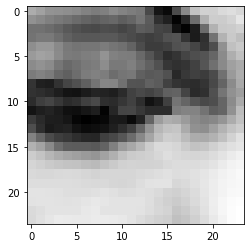

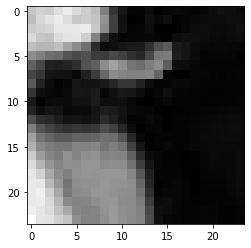

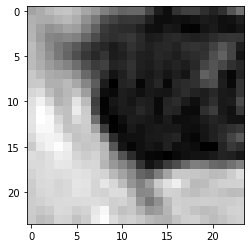

In [21]:
anomaly_dbscan =  plot_anomaly(val_dataset, pred)

## поищем выбросы доп

<AxesSubplot:>

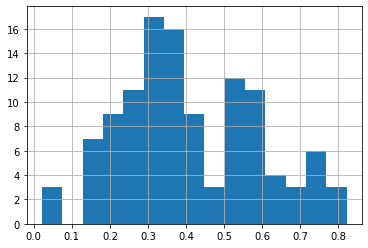

In [32]:
std_mas = [torch.mean(val_dataset[i][0][0]) for i in range(len(val_dataset))]
data = pd.DataFrame(std_mas)
data[0].hist(bins=15)

In [33]:
q75,q25 = np.percentile(data.loc[:,0],[75,25])
intr_qr = q75-q25
treash_max = q75+(1.5*intr_qr)
treash_min = q25-(1.5*intr_qr)
print(treash_min, treash_max)
boolmas = [True if i > treash_max or i < treash_min  else False for en, i in enumerate(std_mas)]
# boolmas = [True if i > 0.9 else False for en, i in enumerate(std_mas)]
dop_anamal = plot_anomaly(val_dataset, boolmas, True)

-0.10688740760087967 0.9322397634387016


In [30]:
sum(boolmas)

0

In [24]:
# anomal_list = anomaly_dbscan + dop_anamal[:2] + dop_anamal[-2:]
# val_dataset = [i for en, i in enumerate(val_dataset) if en not in anomal_list]
# val_dataloader = torch.utils.data.DataLoader(
# val_dataset, batch_size=8, shuffle=False)

## полуконтролируемая кластеризация

In [22]:
def best_threshold(y_true, y_pred, step = 0.000000000007, start = 0.000000000002, count = 10):
    """какой accuracy будет на test, 
    если я оставлю значения в которых модель уверенна выше определенного порога"""
    print("качесвто на test", 
    accuracy_score(y_true, [1 if i >= 0.5 else 0 for i in y_pred]))
    for threshold in np.arange(start, step * count, step):
        bol_mas = ((y_pred > 1 - threshold) | (y_pred < threshold))
        true = y_true[bol_mas]
        pred = y_pred[bol_mas]
        pred_r =  [1 if i >= 0.5 else 0 for i in pred]
        accuracy = round(accuracy_score(true, pred_r), 5) if len(true)> 0 else 0
        print(f"порог: {threshold},   кол-во элементов из test: {len(true)},\
 accuracy: {accuracy}")
    
def map_val_set(model, val_dataset, val_dataloader = None):
    # threshold = 0.0002
    threshold = float(input('выберете порог '))
    if val_dataloader == None:
        y_pred = model.predict_proba(val_dataset)[:, 0]
    else:
        y_pred = model.predict(val_dataloader)
    if len(y_pred) != len(val_dataset):
        raise '2'
    bol_mas = [(y_pred > 1 - threshold) | (y_pred < threshold)][0]
    label = [1 if i >= 0.5 else 0 for i in y_pred]
    return bol_mas, label

def load_new_val(bool_mas, label, train_dataset, val_dataset):
    new_open = []
    new_closed = []
    for val, bools, lab in zip(val_dataset, bool_mas, label):
        if bools == True and lab == 1:
            new_open.append(val[2])
        if bools == True and lab == 2:
            new_closed.append(val[2])
    print(f"кол-во новых фотографий {len(new_open) + len(new_closed)} из {len(val_dataset)} valid датафрейма")
    [os.system(f"mv '{file}' ./train/open") for file in new_open ]
    [os.system(f"mv '{file}' ./train/cloesd") for file in new_closed ]
    t1,t2 = train_load()
    v1, v2 = val_load()
    return t1, t2, v1, v2

def confident_predict_cluster(train_data, train_label, test_data, 
    test_label, val_data, train_dataset, val_dataset, step=0.05, start=0.02):
    label_spread = LabelSpreading(n_jobs = -1, kernel = 'knn')
    pca = PCA(n_components = 10, random_state=6)
    train_data_pca = pca.fit_transform(train_data)
    test_data_pca = pca.transform(test_data)
    val_data_pca = pca.transform(val_data)
    label_spread.fit(train_data_pca, train_label)
    pred_test = label_spread.predict(test_data_pca)
    pred_test_prob = label_spread.predict_proba(test_data_pca)
    best_threshold(test_label, pred_test_prob[:, 1], step, start)
    bool_mas, label = map_val_set(label_spread, val_data_pca)
    return load_new_val(bool_mas, label, train_dataset, val_dataset)
    

In [80]:
train_dataset2, train_dataloader2, val_dataset2, val_dataloader2 = confident_predict_cluster(
train_data, train_label, test_data, test_label, val_set,  train_dataset, val_dataset, step = 0.002, start = 0.005)

качесвто на test 0.7708978328173375
порог: 0.005,   кол-во элементов из test: 63, accuracy: 0.98413
порог: 0.007,   кол-во элементов из test: 81, accuracy: 0.98765
порог: 0.009000000000000001,   кол-во элементов из test: 103, accuracy: 0.97087
порог: 0.011,   кол-во элементов из test: 125, accuracy: 0.96
порог: 0.013000000000000001,   кол-во элементов из test: 134, accuracy: 0.96269
порог: 0.015,   кол-во элементов из test: 144, accuracy: 0.96528
порог: 0.017,   кол-во элементов из test: 152, accuracy: 0.96711
порог: 0.019,   кол-во элементов из test: 163, accuracy: 0.96933
выберете порог 0.019
кол-во новых фотографий 132 из 1087 valid датафрейма


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [82]:
train_dataset, train_dataloader, val_dataset, val_dataloader  = \
train_dataset2, train_dataloader2, val_dataset2, val_dataloader2 

76812

In [83]:
openeyes.fit(train_dataloader, test_dataloader)

Epoch 0/10000:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train accuracy of the network 92.9451127428006, Loss 1517.7793837499921


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val accuracy of the network 96.38802889576884, Loss 16.497393210635437
Epoch 1/10000:
train accuracy of the network 93.01931989793262, Loss 933.0085220569745
val accuracy of the network 96.80082559339526, Loss 21.752428618999446
Epoch 2/10000:
train accuracy of the network 93.00890485861584, Loss 898.7259320260491
val accuracy of the network 96.80082559339526, Loss 17.980569917688825
Epoch 3/10000:
train accuracy of the network 93.03754621673697, Loss 883.0773834269494
val accuracy of the network 96.59442724458205, Loss 18.42175478026411
Epoch 4/10000:
train accuracy of the network 93.09482893297923, Loss 880.1434352034703
val accuracy of the network 96.59442724458205, Loss 18.65552331874676
Epoch 5/10000:
train accuracy of the network 93.08050825391865, Loss 878.9847723096609
val accuracy of the network 96.59442724458205, Loss 19.115627667657478
Epoch 6/10000:
train accuracy of the network 93.0674894547727, Loss 882.300742178224
val accuracy of the network 96.80082559339526, Loss 20.2

KeyboardInterrupt: ignored

#### анализ уверенности  модели

In [23]:
def confident_predict(model , val_dataset, val_dataloader, train_dataset, 
    train_dataloader, test_dataloader, step=0.05, start=0.02):
    y_pred = model.predict(test_dataloader)
    y_true = np.array([i[1] for i in test_dataset])
    best_threshold(y_true, y_pred, step, start)
    bool_mas, label = map_val_set(model, val_dataset, val_dataloader)
    return load_new_val(bool_mas, label, train_dataset, val_dataset)

In [24]:
train_dataset2, train_dataloader2, val_dataset2, val_dataloader2  = confident_predict(
openeyes, val_dataset,val_dataloader, train_dataset, train_dataloader, test_dataloader, 
step=0.007, start=0.002)

  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 122/122 [00:02<00:00, 56.80it/s]


качесвто на test 0.9680082559339526
порог: 0.002,   кол-во элементов из test: 715, accuracy: 1.0
порог: 0.009000000000000001,   кол-во элементов из test: 842, accuracy: 0.99169
порог: 0.016,   кол-во элементов из test: 868, accuracy: 0.99078
порог: 0.023000000000000007,   кол-во элементов из test: 880, accuracy: 0.98977
порог: 0.030000000000000006,   кол-во элементов из test: 887, accuracy: 0.98873
порог: 0.037000000000000005,   кол-во элементов из test: 895, accuracy: 0.98883
порог: 0.04400000000000001,   кол-во элементов из test: 905, accuracy: 0.98674
порог: 0.05100000000000001,   кол-во элементов из test: 907, accuracy: 0.98677
порог: 0.05800000000000001,   кол-во элементов из test: 912, accuracy: 0.98684
порог: 0.06500000000000002,   кол-во элементов из test: 917, accuracy: 0.98473
выберете порог 0.002


100%|██████████| 137/137 [00:01<00:00, 87.06it/s]


кол-во новых фотографий 450 из 1096 valid датафрейма


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_dataset, train_dataloader, val_dataset, val_dataloader  = \
train_dataset2, train_dataloader2, val_dataset2, val_dataloader2 

In [26]:
openeyes.fit(train_dataloader, test_dataloader)

Epoch 0/10000:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train accuracy of the network 98.42483993427389, Loss 206.2033022416581


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val accuracy of the network 96.90402476780186, Loss 12.3391136338887
Epoch 1/10000:
train accuracy of the network 98.52569550682759, Loss 192.67844018297183
val accuracy of the network 97.00722394220847, Loss 13.269321901928379
Epoch 2/10000:
train accuracy of the network 98.63674995750468, Loss 184.0296293843894
val accuracy of the network 96.90402476780186, Loss 13.280489092208654
Epoch 3/10000:


KeyboardInterrupt: ignored

## Итоги

In [27]:
my_pred = openeyes.predict(test_dataloader)

  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 122/122 [00:02<00:00, 57.60it/s]


In [30]:
fpr, tpr, threshold = roc_curve(test_label, my_pred, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('EER',  EER)
print('roc_auc_score', roc_auc_score(test_label, [1 if i >= 0.5 else 0 for i in my_pred]))

EER 0.030991735537190084
roc_auc_score 0.9731554059810854


In [29]:
print("сколько элементов остались не размеченными", len(val_dataset))

сколько элементов остались не размеченными 646
